# Summary

#### Aim: 
Use unsupervised learning (clustering and PCA) to uncover patterns in airline passenger behavior and satisfaction levels, and identify meaningful passenger segments. 

#### Data:
- **Source:** [Maven Analytics](https://www.mavenanalytics.io/data-playground?order=date_added%2Cdesc&search=airline%20passenger).  
- **Dataset:** airline_passenger_satisfaction.csv - Customer satisfaction scores from 120,000+ airline passengers, including additional information about each passenger, their flight, and type of travel, as well as their evaluation of different factors like cleanliness, comfort, service, and overall experience..

#### Method:
- One-hot encoding of categorical variables and standardization of data using RobustScaler. Labels were removed.
- KMeans cluster analysis with default parameters and optimised number of clusters based on Elbow and Silhouette scores.
- HDBSCAN cluster analysis with default parameters. Minimum cluster size and minimum number of samples were tuned on a random sample of 12000 passengers using noise level and Silhouette score. Model with tuned parameters was fit to whole data set.
- PCA dimensionality reduction analysis with default parameters and optimised number of components based on Scree plot.

#### Results and findings:
PCA, KMeans and DBSCAN, showed flight delays as the major component in the data variance. PCA was able to identify two other underlying patterns in the data that the clustering analysis couldn't: 
one related to overall service and one related to tech and comfort satisfaction.

Clusters are not completely separated in the PCA space given that real-world customer experiences often exist on spectrums with not clean divisions.

For short flight delays (low PC1), the service values (PC1/PC2) are very extreme, indicating that some passengers are:
- very satisfied → good flight + good service = delighted.
- very dissatisfied → maybe expectations were high, or service was bad despite punctuality.

However, as flight delays increase the satisfaction levels tend to be more neutral (closer to zero), especially for the tech and comfort component. This tells that when delays are great, tech and comfort 
does not improve the passengers' experience. 

There seems to be a tradeoff between overall service and tech/comfort satisfaction, although there are slightly more people with negative tech/comfort satisfaction than positive. The biggest groups seem to 
be:
- positive overall service with negative tech/comfort satisfaction
- negative overall service with negative tech/comfort satisfaction

#### Future improvements or considerations:
Further investigation of the KMeans clusters:
- Examine correlation heatmaps of service-related features within each cluster to better understand what defines these groups.

- Identify which customer types (e.g., business vs. personal, returning vs. new) are most dominant in each cluster.

- Analyze the cluster centroids to uncover deeper insights about the typical passenger in each group.

Repeat the analysis after removing the delay features to see if other underlying patterns become more evident.

Explore soft clustering techniques:

- Use Gaussian Mixture Models (GMM), which assign each passenger a probability of belonging to each cluster, rather than forcing a hard assignment.

- Soft clustering is particularly useful when clusters overlap or boundaries are unclear, as it can better capture nuanced, ambiguous, or transitional passenger patterns that hard clustering methods like KMeans and HDBSCAN may miss.

# Data Dictionary
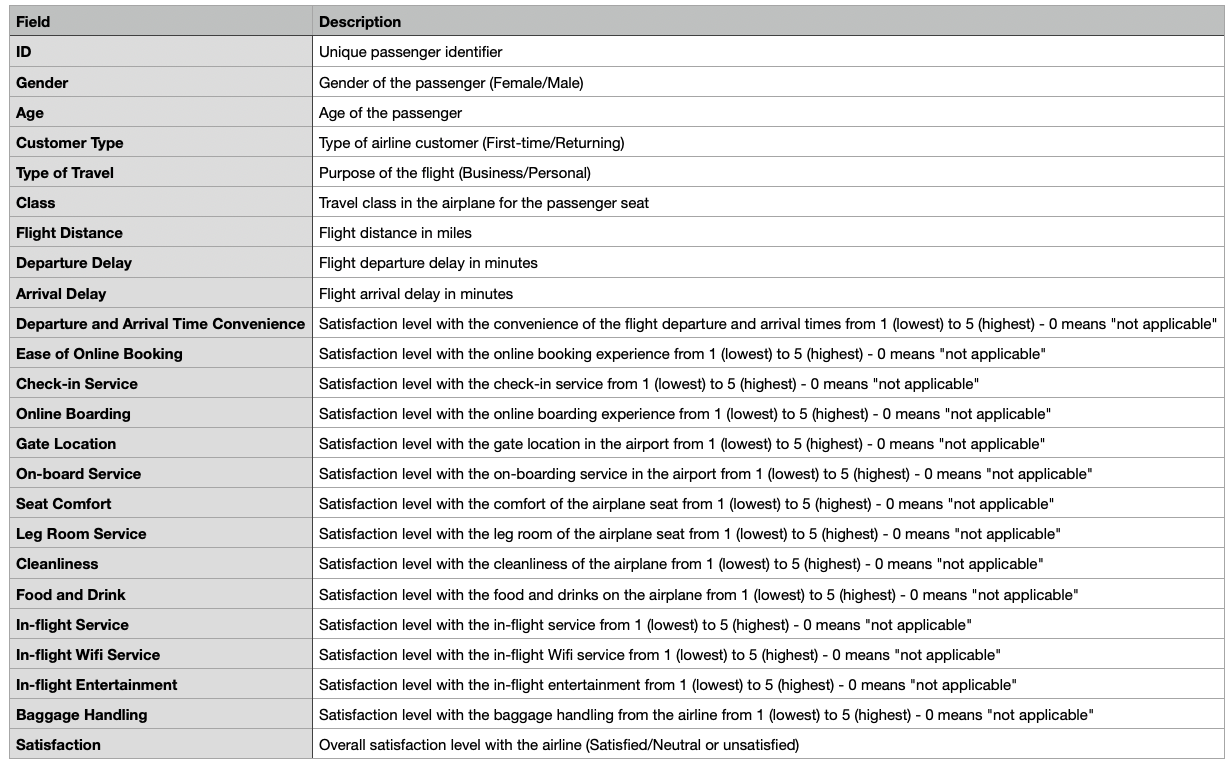

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import hdbscan

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap



# 1. Reading data and EDA
## 1.1 Basic Structure and summary

In [2]:
# Read the data
data = pd.read_csv("airline_passenger_satisfaction.csv", index_col=0)
pd.set_option('display.max_columns', None)
data.head()

,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
ID,,,,,,,,,,,,,,,,,,,,,,,
1,Male,48,First-time,Business,Business,821,2,5.0,3,3,4,3,3,3,5,2,5,5,5,3,5,5,Neutral or Dissatisfied
2,Female,35,Returning,Business,Business,821,26,39.0,2,2,3,5,2,5,4,5,5,3,5,2,5,5,Satisfied
3,Male,41,Returning,Business,Business,853,0,0.0,4,4,4,5,4,3,5,3,5,5,3,4,3,3,Satisfied
4,Male,50,Returning,Business,Business,1905,0,0.0,2,2,3,4,2,5,5,5,4,4,5,2,5,5,Satisfied
5,Female,49,Returning,Business,Business,3470,0,1.0,3,3,3,5,3,3,4,4,5,4,3,3,3,3,Satisfied


In [3]:
data.tail()

,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
ID,,,,,,,,,,,,,,,,,,,,,,,
129876,Male,28,Returning,Personal,Economy Plus,447,2,3.0,4,4,4,4,2,5,1,4,4,4,5,4,4,4,Neutral or Dissatisfied
129877,Male,41,Returning,Personal,Economy Plus,308,0,0.0,5,3,5,3,4,5,2,5,2,2,4,3,2,5,Neutral or Dissatisfied
129878,Male,42,Returning,Personal,Economy Plus,337,6,14.0,5,2,4,2,1,3,3,4,3,3,4,2,3,5,Neutral or Dissatisfied
129879,Male,50,Returning,Personal,Economy Plus,337,31,22.0,4,4,3,4,1,4,4,5,3,3,4,5,3,5,Satisfied
129880,Female,20,Returning,Personal,Economy Plus,337,0,0.0,1,3,4,3,2,4,2,4,2,2,2,3,2,1,Neutral or Dissatisfied


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129880 entries, 1 to 129880
Data columns (total 23 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Gender                                  129880 non-null  object 
 1   Age                                     129880 non-null  int64  
 2   Customer Type                           129880 non-null  object 
 3   Type of Travel                          129880 non-null  object 
 4   Class                                   129880 non-null  object 
 5   Flight Distance                         129880 non-null  int64  
 6   Departure Delay                         129880 non-null  int64  
 7   Arrival Delay                           129487 non-null  float64
 8   Departure and Arrival Time Convenience  129880 non-null  int64  
 9   Ease of Online Booking                  129880 non-null  int64  
 10  Check-in Service                        129880 no

In [5]:
data.shape

(129880, 23)

In [6]:
# check for NaNs
data.isnull().sum()


Gender                                      0
Age                                         0
Customer Type                               0
Type of Travel                              0
Class                                       0
Flight Distance                             0
Departure Delay                             0
Arrival Delay                             393
Departure and Arrival Time Convenience      0
Ease of Online Booking                      0
Check-in Service                            0
Online Boarding                             0
Gate Location                               0
On-board Service                            0
Seat Comfort                                0
Leg Room Service                            0
Cleanliness                                 0
Food and Drink                              0
In-flight Service                           0
In-flight Wifi Service                      0
In-flight Entertainment                     0
Baggage Handling                  

In [7]:
data.describe()

,Age,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling
count,129880.000000,129880.000000,129880.000000,129487.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000
mean,39.427957,1190.316392,14.713713,15.091129,3.057599,2.756876,3.306267,3.252633,2.976925,3.383023,3.441361,3.350878,3.286326,3.204774,3.642193,2.728696,3.358077,3.632114
std,15.119360,997.452477,38.071126,38.465650,1.526741,1.401740,1.266185,1.350719,1.278520,1.287099,1.319289,1.316252,1.313682,1.329933,1.176669,1.329340,1.334049,1.180025
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,27.000000,414.000000,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000
50%,40.000000,844.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000
75%,51.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,5.000000
max,85.000000,4983.000000,1592.000000,1584.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [8]:
# Remove spaces in column names
data.columns=data.columns.str.replace(" ","_")
data.columns

Index(['Gender', 'Age', 'Customer_Type', 'Type_of_Travel', 'Class',
       'Flight_Distance', 'Departure_Delay', 'Arrival_Delay',
       'Departure_and_Arrival_Time_Convenience', 'Ease_of_Online_Booking',
       'Check-in_Service', 'Online_Boarding', 'Gate_Location',
       'On-board_Service', 'Seat_Comfort', 'Leg_Room_Service', 'Cleanliness',
       'Food_and_Drink', 'In-flight_Service', 'In-flight_Wifi_Service',
       'In-flight_Entertainment', 'Baggage_Handling', 'Satisfaction'],
      dtype='object')

In [9]:
# Remove dashes in column names
data.columns=data.columns.str.replace("-","")
data.columns

Index(['Gender', 'Age', 'Customer_Type', 'Type_of_Travel', 'Class',
       'Flight_Distance', 'Departure_Delay', 'Arrival_Delay',
       'Departure_and_Arrival_Time_Convenience', 'Ease_of_Online_Booking',
       'Checkin_Service', 'Online_Boarding', 'Gate_Location',
       'Onboard_Service', 'Seat_Comfort', 'Leg_Room_Service', 'Cleanliness',
       'Food_and_Drink', 'Inflight_Service', 'Inflight_Wifi_Service',
       'Inflight_Entertainment', 'Baggage_Handling', 'Satisfaction'],
      dtype='object')

In [10]:
# Checking for flight distances that seem too short
data[data['Flight_Distance'] <= 50]

,Gender,Age,Customer_Type,Type_of_Travel,Class,Flight_Distance,Departure_Delay,Arrival_Delay,Departure_and_Arrival_Time_Convenience,Ease_of_Online_Booking,Checkin_Service,Online_Boarding,Gate_Location,Onboard_Service,Seat_Comfort,Leg_Room_Service,Cleanliness,Food_and_Drink,Inflight_Service,Inflight_Wifi_Service,Inflight_Entertainment,Baggage_Handling,Satisfaction
ID,,,,,,,,,,,,,,,,,,,,,,,
29816,Female,38,Returning,Business,Economy,31,0,0.0,2,2,5,4,2,4,4,4,4,4,2,4,4,3,Satisfied
29824,Female,23,First-time,Business,Economy,31,0,0.0,0,4,5,4,1,1,1,3,1,1,2,4,1,4,Satisfied
29863,Female,53,Returning,Business,Economy,31,0,0.0,3,3,3,5,3,5,4,5,3,4,5,5,5,5,Satisfied
29992,Female,26,First-time,Business,Economy,31,0,0.0,0,4,5,4,1,5,3,3,3,3,2,4,3,5,Neutral or Dissatisfied
30078,Female,22,Returning,Personal,Economy,31,0,0.0,5,2,5,2,3,3,5,2,5,5,4,2,5,4,Neutral or Dissatisfied
30125,Female,54,Returning,Personal,Economy,31,18,22.0,1,2,3,4,3,5,4,2,2,4,5,2,5,5,Neutral or Dissatisfied
30130,Female,12,Returning,Personal,Economy,31,12,8.0,4,3,5,3,4,1,1,1,1,1,1,3,1,2,Neutral or Dissatisfied
30133,Male,70,Returning,Personal,Economy,31,0,0.0,5,0,3,0,4,3,4,5,4,4,4,2,4,5,Neutral or Dissatisfied
30144,Female,17,Returning,Personal,Economy,31,11,11.0,4,0,4,0,3,4,1,3,1,1,5,2,1,5,Neutral or Dissatisfied


## 1.2 Univariate data analysis

In [11]:
# Frequency counts for categorical data

cat_var = data.select_dtypes(include='object') # Select only categorical columns

for col in cat_var:
    print(f"\nValue counts for: {col}")
    print(data[col].value_counts())


Value counts for: Gender
Gender
Female    65899
Male      63981
Name: count, dtype: int64

Value counts for: Customer_Type
Customer_Type
Returning     106100
First-time     23780
Name: count, dtype: int64

Value counts for: Type_of_Travel
Type_of_Travel
Business    89693
Personal    40187
Name: count, dtype: int64

Value counts for: Class
Class
Business        62160
Economy         58309
Economy Plus     9411
Name: count, dtype: int64

Value counts for: Satisfaction
Satisfaction
Neutral or Dissatisfied    73452
Satisfied                  56428
Name: count, dtype: int64


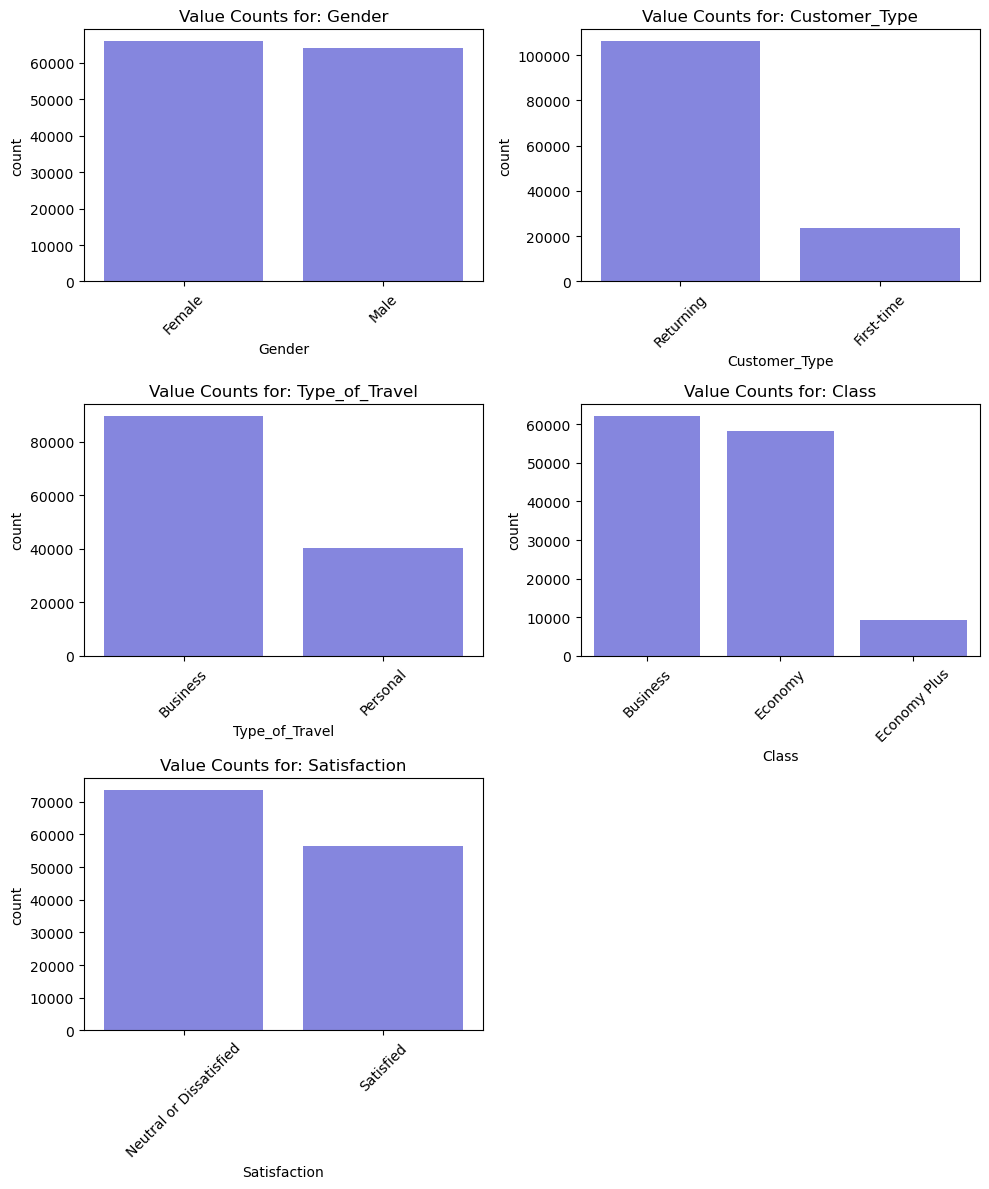

In [12]:
# Barplots for frequency counts

# Define a custom palette to use in notebook
custom_palette = sns.color_palette(["#3D348B","#7678ED", "#F7B801", "#F18701", "#F35B04"])

# Define layout
cols_per_row = 2
rows = 3

# Set overall figure size
plt.figure(figsize=(cols_per_row * 5, rows * 4))

# Plot each categorical column
for i, col in enumerate(cat_var, 1):
    plt.subplot(rows, cols_per_row, i)
    sns.countplot(data=data, x=col, order=data[col].value_counts().index, color=custom_palette[1])
    plt.title(f'Value Counts for: {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

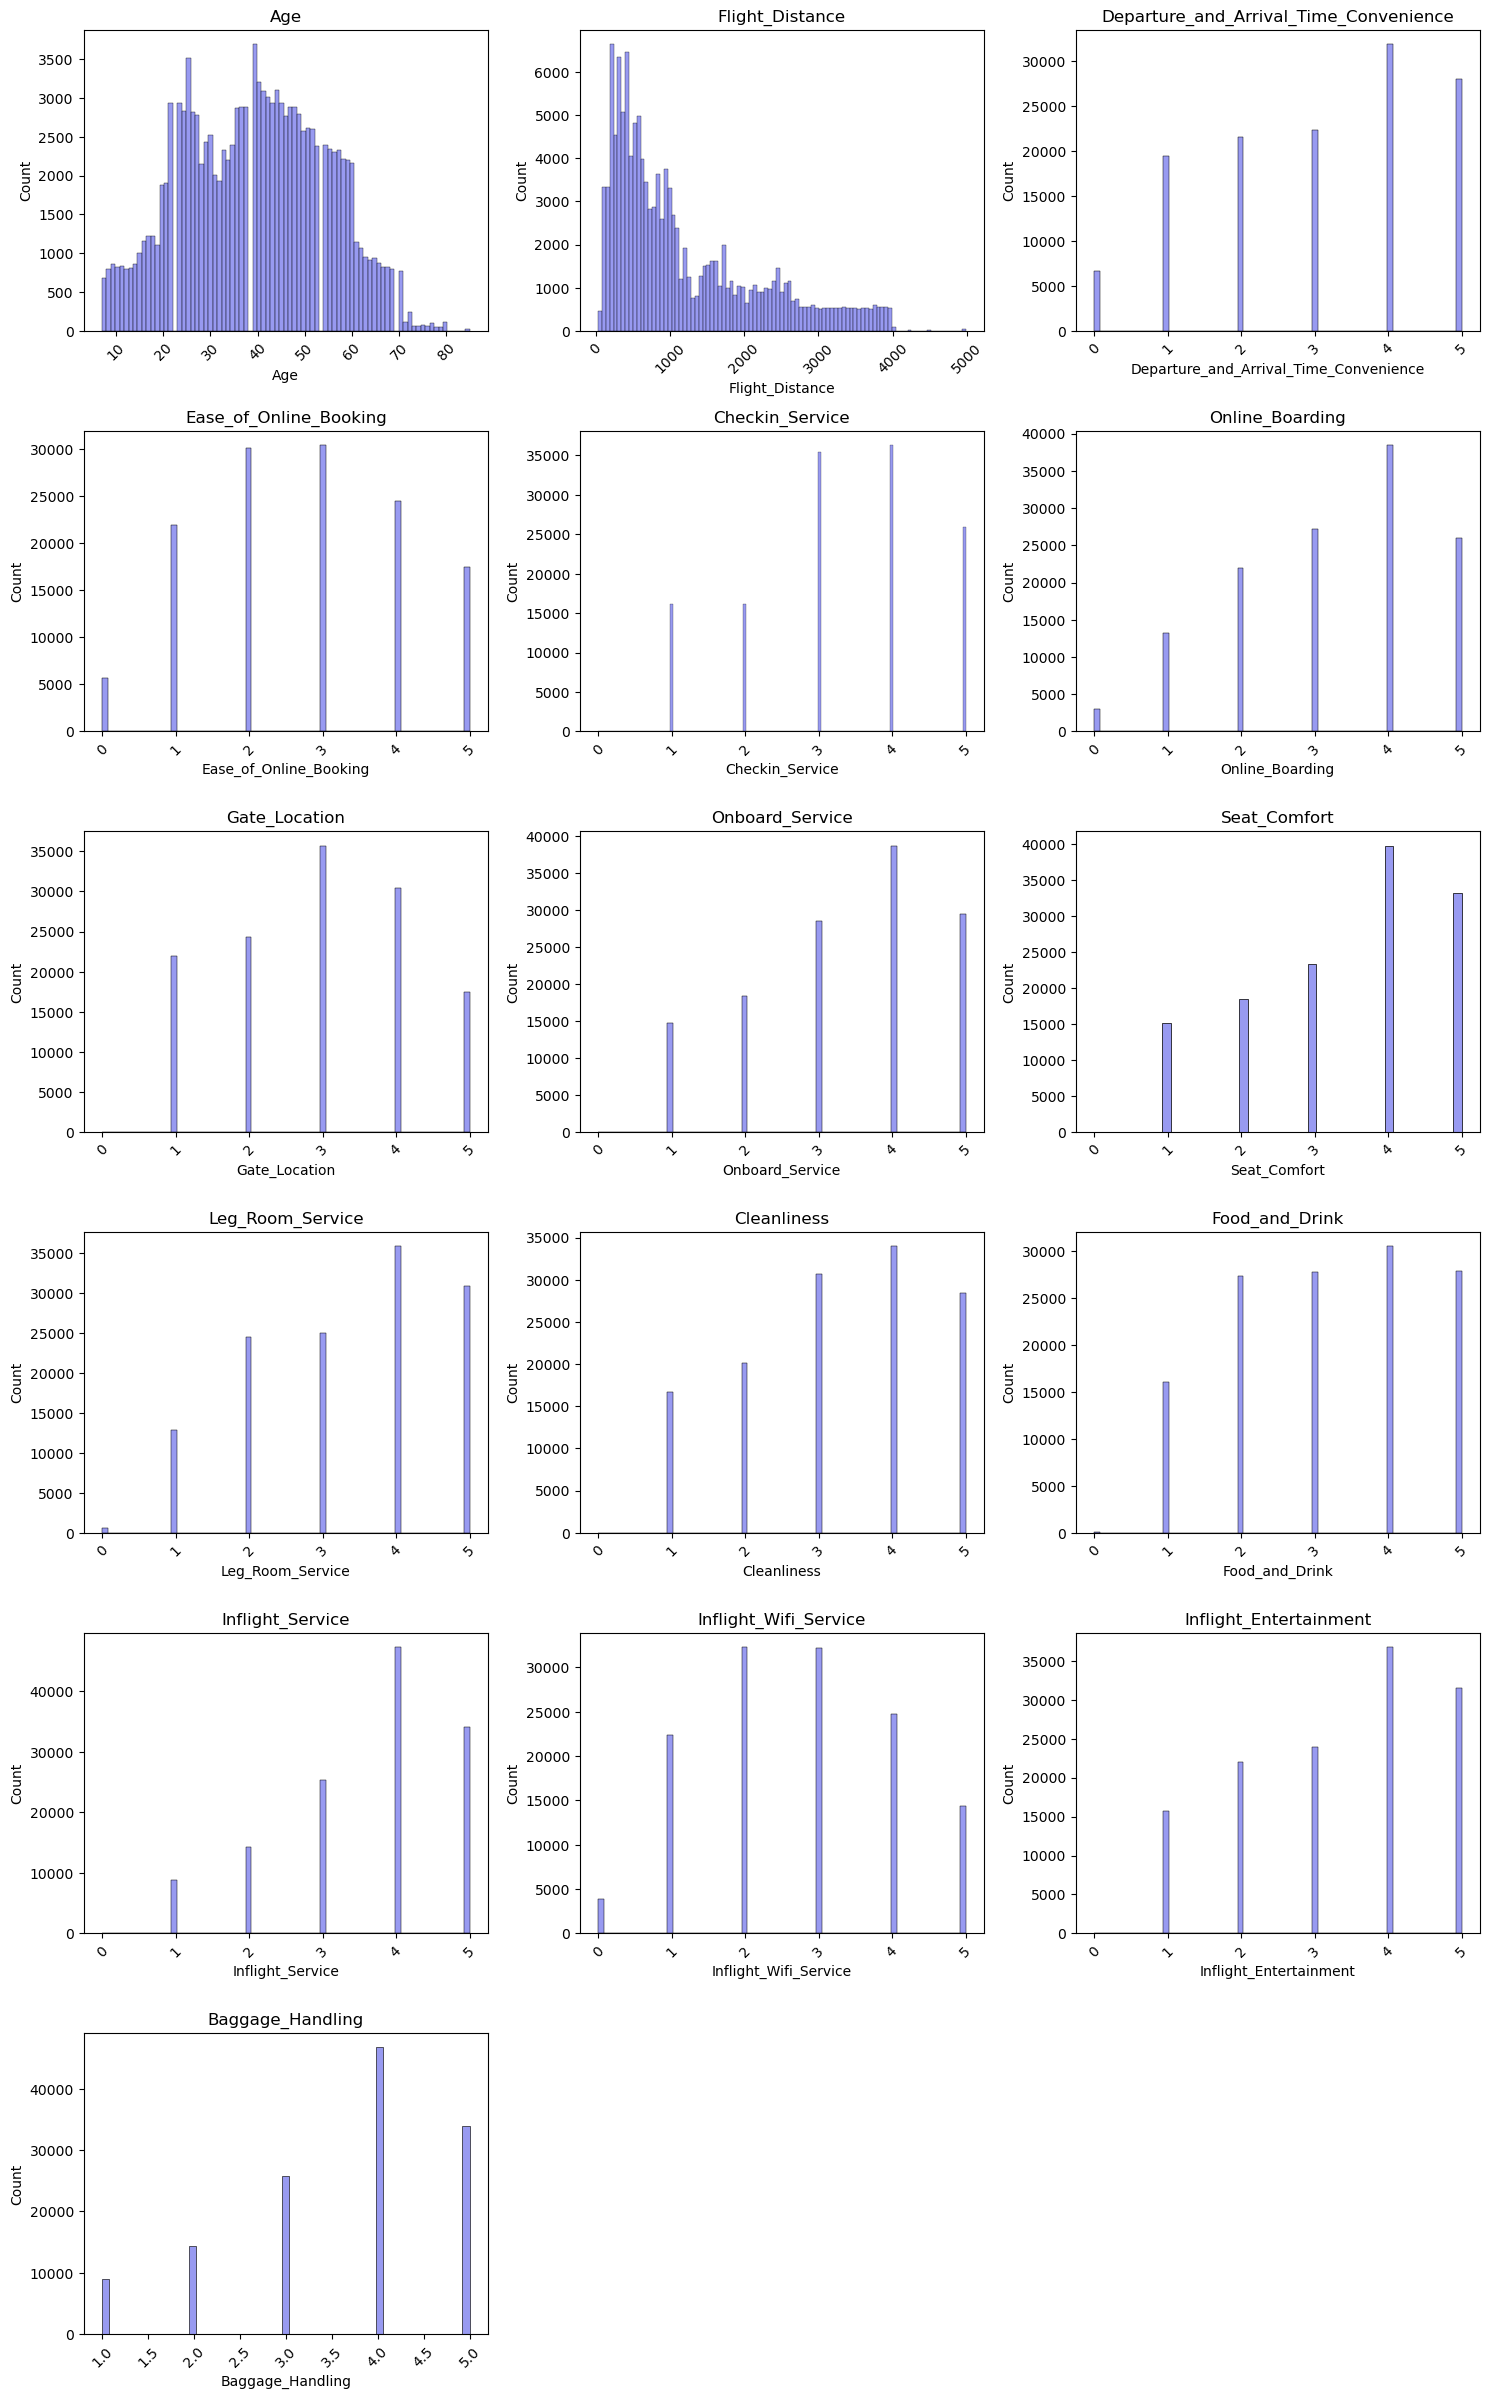

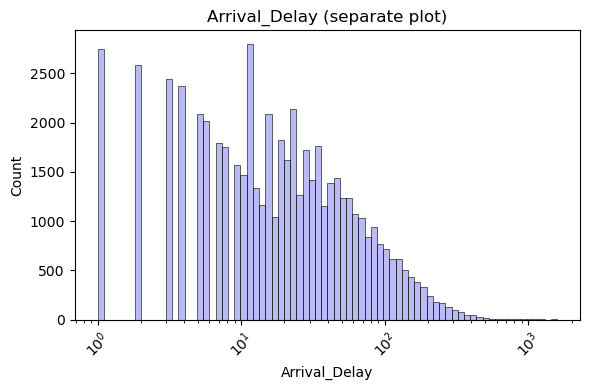

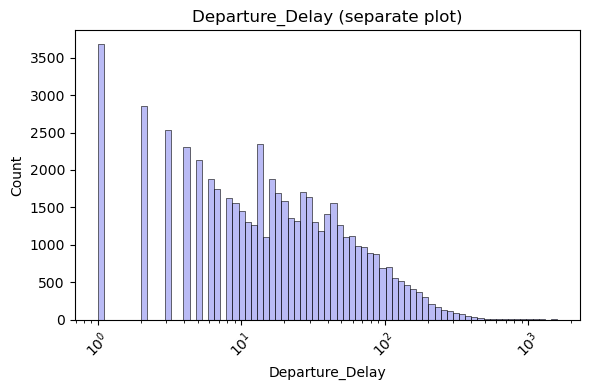

In [13]:
# Histograms for numerical variables

num_var = data.select_dtypes(include='number') # Select only numeric columns

# Exclude delay columns for custom plotting
exclude_cols = ["Arrival_Delay", "Departure_Delay"]
plot_cols = [col for col in num_var.columns if col not in exclude_cols]

# Main grid for non-delay variables
cols_per_row = 3
plt.figure(figsize=(cols_per_row * 5, math.ceil(len(plot_cols) / cols_per_row) * 4))

for i, col in enumerate(plot_cols, 1):
    plt.subplot(math.ceil(len(plot_cols) / cols_per_row), cols_per_row, i)
    sns.histplot(x=num_var[col], color=custom_palette[1])
    plt.title(f'{col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Separate plots for delay columns with log scale or adjusted limits
for col in exclude_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(x=num_var[col], log_scale=True, kde=True, color=custom_palette[1]) # log scale for extremely skewed data
    plt.title(f'{col} (separate plot)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [14]:
# Calculate the 85th percentile for Departure_Delay and Arrival_Delay
percentile_85d = np.percentile(data['Departure_Delay'], 85)
percentile_85a = np.percentile(data['Arrival_Delay'].dropna(), 85)

# Print the result
print(f"85th Percentile of Departure_Delay: {percentile_85d}")
print(f"85th Percentile of Arrival_Delay: {percentile_85a}")

85th Percentile of Departure_Delay: 28.0
85th Percentile of Arrival_Delay: 29.0


## 1.3 Bivariate data analysis

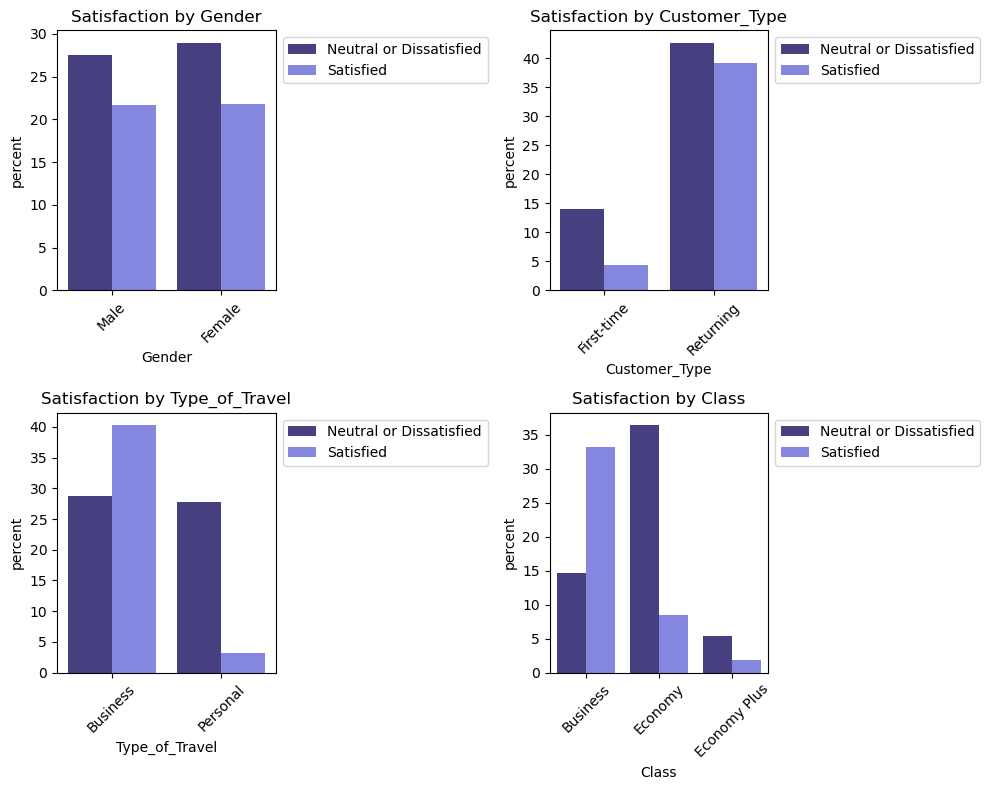

In [15]:
# Satisfaction levels by 'Customer_Type', 'Class', 'Type_of_Travel', 'Gender'
group_vars = cat_var.drop("Satisfaction", axis=1)

plt.figure(figsize=(10,8))
for i, var in enumerate(group_vars,1):
    ax = plt.subplot(2, 2, i)
    sns.countplot(data=data, x=var, stat='percent' ,hue='Satisfaction', palette = custom_palette[0:2])
    plt.title(f'Satisfaction by {var}')
    plt.xticks(rotation=45)

    # Move the legend to the top-right outside the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

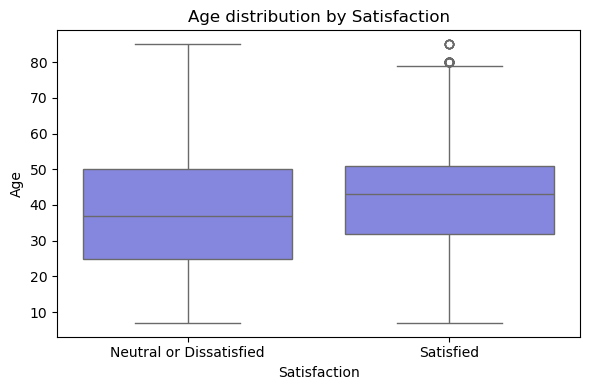

In [16]:
# Checking Satisfaction by Age
plt.figure(figsize=(6,4))
sns.boxplot(data=data,  x="Satisfaction", y="Age", color = custom_palette[1])
plt.title("Age distribution by Satisfaction")
plt.tight_layout()
plt.show()

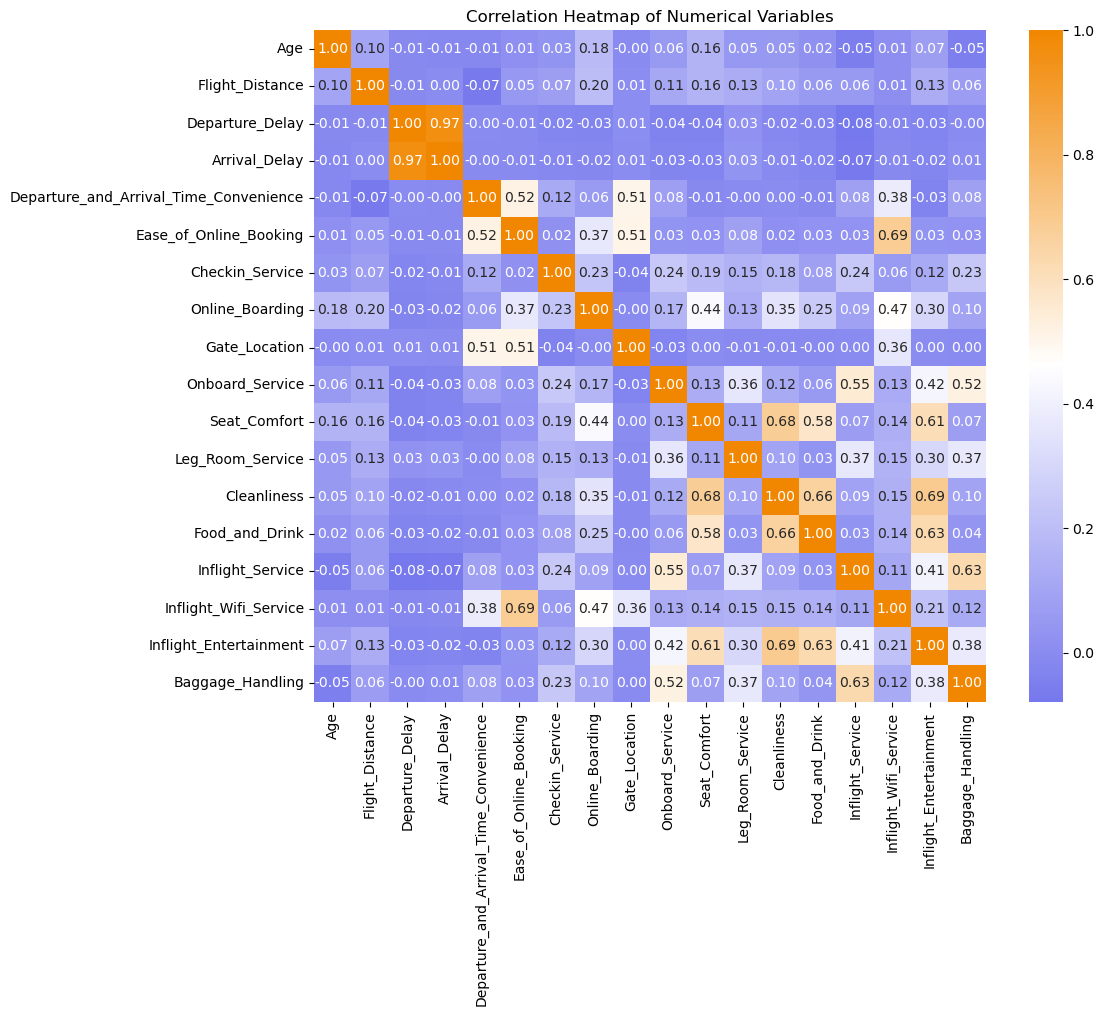

In [17]:
# Heatmap of numerical variables

# Replace 0s in rating columns with NaN since 0 = "Not Applicable"
num_var = num_var.replace(0, np.nan)

# Correlation heatmap
custom_cmap = LinearSegmentedColormap.from_list(None, [custom_palette[1], "white", custom_palette[3]]) # define custom colormap

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(num_var.corr(), annot=True, cmap = custom_cmap, fmt=".2f", square=True)
plt.title("Correlation Heatmap of Numerical Variables")
plt.tight_layout()
plt.show()

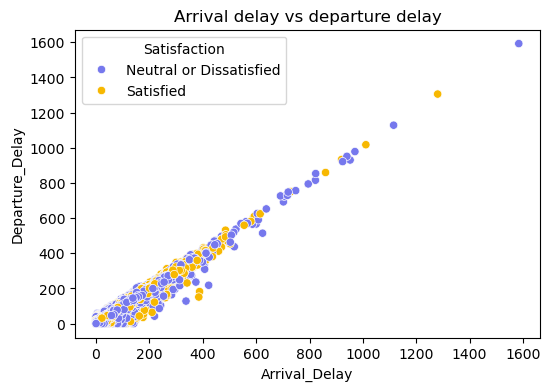

In [18]:
# Arrival delay vs Departure relay
plt.figure(figsize=(6,4))
sns.scatterplot(data=data, x='Arrival_Delay', y='Departure_Delay', hue='Satisfaction', palette=custom_palette[1:3])
plt.title("Arrival delay vs departure delay" )
plt.show()

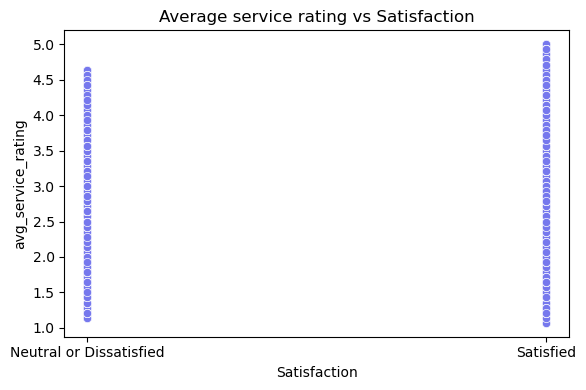

In [19]:
# Creating an average satisfaction numerical feature

rating_vars = ['Departure_and_Arrival_Time_Convenience', 'Ease_of_Online_Booking',
       'Checkin_Service', 'Online_Boarding', 'Gate_Location',
       'Onboard_Service', 'Seat_Comfort', 'Leg_Room_Service', 'Cleanliness',
       'Food_and_Drink', 'Inflight_Service', 'Inflight_Wifi_Service',
       'Inflight_Entertainment', 'Baggage_Handling']

data["avg_service_rating"] = data[rating_vars].mean(axis=1)

# Comparing average satisfaction with declared satisfaction level

plt.figure(figsize=(6,4))
sns.scatterplot(data=data, x="Satisfaction", y="avg_service_rating", color = custom_palette[1])
plt.title("Average service rating vs Satisfaction")
plt.tight_layout()
plt.show()


In [20]:
# Map Satisfaction to binary: 1 = Satisfied, 0 = Neutral or Dissatisfied
data["Satisfaction_binary"] = data["Satisfaction"].map({
    "Satisfied": 1,
    "Neutral or Dissatisfied": 0
})
data["Satisfaction_binary"].value_counts()


Satisfaction_binary
0    73452
1    56428
Name: count, dtype: int64

In [21]:
# Calculate correlation between avg_service_rating and Satisfaction_binary
print("Correlation coefficient: ", 
      np.corrcoef(data["Satisfaction_binary"],data["avg_service_rating"])[1,0])


Correlation coefficient:  0.4953153141718021


## 1.4 Missing and special values

In [22]:
# Checking counts of "not applicable" ratings
for col in rating_vars:
    zero_count = (data[col] == 0).sum()
    print(f"{col}: {zero_count} zeros")

Departure_and_Arrival_Time_Convenience: 6681 zeros
Ease_of_Online_Booking: 5682 zeros
Checkin_Service: 1 zeros
Online_Boarding: 3080 zeros
Gate_Location: 1 zeros
Onboard_Service: 5 zeros
Seat_Comfort: 1 zeros
Leg_Room_Service: 598 zeros
Cleanliness: 14 zeros
Food_and_Drink: 132 zeros
Inflight_Service: 5 zeros
Inflight_Wifi_Service: 3916 zeros
Inflight_Entertainment: 18 zeros
Baggage_Handling: 0 zeros


In [23]:
# Since these zeros don't carry information, they will be replaced with NaNs
data[rating_vars] = data[rating_vars].replace(0, np.nan)
data[rating_vars].isna().sum()

Departure_and_Arrival_Time_Convenience    6681
Ease_of_Online_Booking                    5682
Checkin_Service                              1
Online_Boarding                           3080
Gate_Location                                1
Onboard_Service                              5
Seat_Comfort                                 1
Leg_Room_Service                           598
Cleanliness                                 14
Food_and_Drink                             132
Inflight_Service                             5
Inflight_Wifi_Service                     3916
Inflight_Entertainment                      18
Baggage_Handling                             0
dtype: int64

In [24]:
# Checking missing values in Arrival Delay
data[data["Arrival_Delay"].isna()]

,Gender,Age,Customer_Type,Type_of_Travel,Class,Flight_Distance,Departure_Delay,Arrival_Delay,Departure_and_Arrival_Time_Convenience,Ease_of_Online_Booking,Checkin_Service,Online_Boarding,Gate_Location,Onboard_Service,Seat_Comfort,Leg_Room_Service,Cleanliness,Food_and_Drink,Inflight_Service,Inflight_Wifi_Service,Inflight_Entertainment,Baggage_Handling,Satisfaction,avg_service_rating,Satisfaction_binary
ID,,,,,,,,,,,,,,,,,,,,,,,,,
247,Male,11,Returning,Business,Business,719,38,NaN,1.0,1.0,4.0,4.0,1.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,4,Neutral or Dissatisfied,3.214286,0
884,Male,39,Returning,Business,Business,396,0,NaN,3.0,5.0,5.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3,Satisfied,3.428571,1
1966,Male,36,Returning,Business,Economy,383,2,NaN,4.0,4.0,4.0,2.0,4.0,5.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,Satisfied,2.857143,1
2408,Female,55,Returning,Business,Business,2904,58,NaN,5.0,5.0,3.0,3.0,5.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,4.0,4,Neutral or Dissatisfied,4.071429,0
2449,Male,21,Returning,Personal,Economy Plus,767,5,NaN,3.0,1.0,1.0,1.0,1.0,4.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1,Neutral or Dissatisfied,1.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129001,Male,46,First-time,Business,Business,2704,7,NaN,3.0,3.0,5.0,3.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,3.0,4.0,3,Neutral or Dissatisfied,3.571429,0
129004,Female,17,First-time,Business,Economy,2704,0,NaN,3.0,3.0,1.0,3.0,3.0,2.0,1.0,4.0,1.0,1.0,3.0,3.0,1.0,4,Neutral or Dissatisfied,2.357143,0
129015,Male,57,Returning,Business,Business,2704,0,NaN,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,5.0,2.0,4.0,4.0,4.0,4,Satisfied,3.857143,1


In [25]:
# Only 393 rows (0.3%) have NaNs in Arrival_Delay column so they are being dropped
data = data.dropna(subset=['Arrival_Delay'])
data["Arrival_Delay"].isna().sum()

0

## 1.5 Grouping and aggregates

In [26]:
# Average ratings per groups

print(data.groupby('Customer_Type')["avg_service_rating"].mean())
print(data.groupby('Class')["avg_service_rating"].mean())
print(data.groupby('Gender')["avg_service_rating"].mean())
print(data.groupby('Type_of_Travel')["avg_service_rating"].mean())



Customer_Type
First-time    3.053681
Returning     3.283316
Name: avg_service_rating, dtype: float64
Class
Business        3.432669
Economy         3.066348
Economy Plus    3.060029
Name: avg_service_rating, dtype: float64
Gender
Female    3.235199
Male      3.247505
Name: avg_service_rating, dtype: float64
Type_of_Travel
Business    3.296489
Personal    3.117894
Name: avg_service_rating, dtype: float64


## Comments:
- Dataset contains 129880 samples and 23 features with 393 missing values in the Arrival_Delay column. Source of the data is unknown but seems to be from an american airline.

- Fourteen of these features are satisfaction scales from 1 (lowest)  to 5 (highest) and 0 for not applicable.

- 51% of the passengers are female and 49% of the passengers are male, therfore there is no gender bias in the sample.

- Age of the passengers ranges from 7 to 85 years old, although 75% of the passengers are 51 years old or younger.

- There are 11 entries with a Flight_Distance of 31 miles which seems very short. Although since further inspection of those entries did not reveal anything else unusual, it is possible that this is a legitimate short-hop route and the records were left as is in the data set.

- 82% of the passengers in the dataset are returning customers and 69% of the passengers fly for business purposes. This suggests that the dataset is biased toward business travellers and frequent flyers, which may influence overall satisfaction trends and behavior patterns.

- Although nearly 48% of passengers flew Business Class and 82% were returning customers — indicating a frequent, high-value traveler base — only 43% reported being satisfied with the airline service. The remaining 57% were neutral or dissatisfied, suggesting that the airline may need to improve aspects of its service to better meet customer expectations, particularly among its core traveler segments.

- The services with the highest proportion of high satisfaction levels (>=4) were: departure and arrival time convenience, checkin service, online boarding, onboard service, seat comfort, leg room, cleanliness, inflight service, inflight entertainment and baggage handling.

- The services with the highest proprtion of low satisfaction scores (<3) were: ease of online booking and inflight wifi service. This suggests potential areas for improvement, particularly in the airline’s digital platforms and connectivity infrastructure.

- Interestingly, while passengers generally enjoyed the in-flight entertainment, they were dissatisfied with the Wi-Fi service. This may reflect frustration among business travellers, who are more likely to need reliable internet access during flights for work purposes.

- While a few outliers experienced delays exceeding 24 hours, delays were generally low — 85% of passengers waited less than 30 minutes, and three-quarters were delayed by 13 minutes or less. As expected, arrival and departure delays showed a strong positive correlation.

- The proportion of dissatisfied/neutral passengers was highest for first-time travellers, people flying for personal reasons and passengers in Economy class.

- Some service ratings showed moderately positive correlation with eachother:
    - inflight entertainment with seat comfort, cleaningless and food/drink.
    - inflight Wifi with ease of online booking.

- Interestingly, there is only a weak positive correlation between the average of all service ratings and the overall satisfaction reported by the passangers. This suggests that satisfaction may be influenced by factors beyond onboard and airport service quality like delays, pricing, expectations, or isolated negative experiences that influence the passenger's overall perception.

# 2. Data Preparation for Clustering and PCA

## 2.1. Select Relevant Features

In [27]:
# Drop Satisfaction, Satisfaction_binary, and avg_service_rating columns
features = data.drop(columns=["Satisfaction", "Satisfaction_binary", "avg_service_rating"])
# Check the final dataset
features.columns

Index(['Gender', 'Age', 'Customer_Type', 'Type_of_Travel', 'Class',
       'Flight_Distance', 'Departure_Delay', 'Arrival_Delay',
       'Departure_and_Arrival_Time_Convenience', 'Ease_of_Online_Booking',
       'Checkin_Service', 'Online_Boarding', 'Gate_Location',
       'Onboard_Service', 'Seat_Comfort', 'Leg_Room_Service', 'Cleanliness',
       'Food_and_Drink', 'Inflight_Service', 'Inflight_Wifi_Service',
       'Inflight_Entertainment', 'Baggage_Handling'],
      dtype='object')

In [28]:
features.shape

(129487, 22)

## 2.2. Encode Categorical Variables

In [29]:
# One-hot encoding will be used for categorical variables since the categories are not ordinal
features = pd.get_dummies(features, drop_first=True)
# Check the final dataset
print(features.columns)
features.shape

Index(['Age', 'Flight_Distance', 'Departure_Delay', 'Arrival_Delay',
       'Departure_and_Arrival_Time_Convenience', 'Ease_of_Online_Booking',
       'Checkin_Service', 'Online_Boarding', 'Gate_Location',
       'Onboard_Service', 'Seat_Comfort', 'Leg_Room_Service', 'Cleanliness',
       'Food_and_Drink', 'Inflight_Service', 'Inflight_Wifi_Service',
       'Inflight_Entertainment', 'Baggage_Handling', 'Gender_Male',
       'Customer_Type_Returning', 'Type_of_Travel_Personal', 'Class_Economy',
       'Class_Economy Plus'],
      dtype='object')


(129487, 23)

## 2.3. Handle Missing or Special Values

In [30]:
# Replacing NaNs in service rating variables with the median

# Define the imputer with the median strategy
imputer = SimpleImputer(strategy='median')

# Apply the imputer to the service rating variables
features[rating_vars] = imputer.fit_transform(features[rating_vars])
features.isna().sum()

Age                                       0
Flight_Distance                           0
Departure_Delay                           0
Arrival_Delay                             0
Departure_and_Arrival_Time_Convenience    0
Ease_of_Online_Booking                    0
Checkin_Service                           0
Online_Boarding                           0
Gate_Location                             0
Onboard_Service                           0
Seat_Comfort                              0
Leg_Room_Service                          0
Cleanliness                               0
Food_and_Drink                            0
Inflight_Service                          0
Inflight_Wifi_Service                     0
Inflight_Entertainment                    0
Baggage_Handling                          0
Gender_Male                               0
Customer_Type_Returning                   0
Type_of_Travel_Personal                   0
Class_Economy                             0
Class_Economy Plus              

## 2.4. Standardize the Data

In [31]:
# Using RobustScaler since features are all positive and some are skewed with ouliers

scaler = RobustScaler()
X = scaler.fit_transform(features) # assign scaled features to variable for cluster and PCA analysis
X[0:5,:]

array([[ 0.33333333, -0.01729323,  0.16666667,  0.38461538,  0.        ,
         0.        ,  1.        , -0.5       ,  0.        , -0.5       ,
         0.33333333, -1.        ,  1.        ,  1.        ,  0.5       ,
         0.        ,  0.5       ,  0.5       ,  1.        , -1.        ,
         0.        ,  0.        ,  0.        ],
       [-0.20833333, -0.01729323,  2.16666667,  3.        , -0.5       ,
        -0.5       ,  0.        ,  0.5       , -0.5       ,  0.5       ,
         0.        ,  0.5       ,  1.        ,  0.        ,  0.5       ,
        -0.5       ,  0.5       ,  0.5       ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.04166667,  0.00676692,  0.        ,  0.        ,  0.5       ,
         0.5       ,  1.        ,  0.5       ,  0.5       , -0.5       ,
         0.33333333, -0.5       ,  1.        ,  1.        , -0.5       ,
         0.5       , -0.5       , -0.5       ,  1.        ,  0.        ,
         0.        ,  0.    

# 3. Clustering Analysis

## 3.1. K-Means Clustering

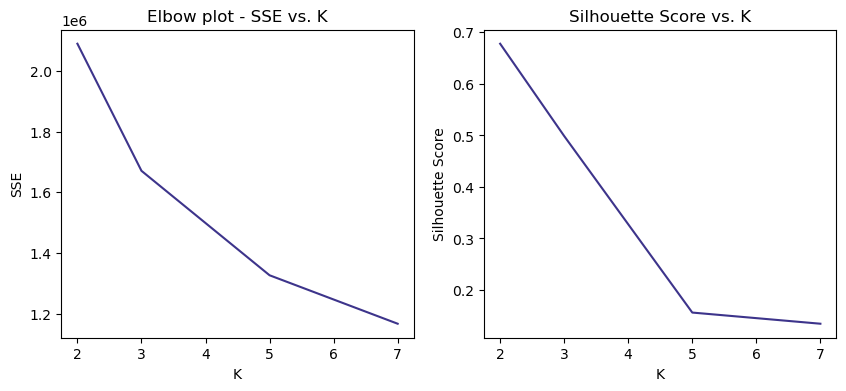

In [32]:
# Selecting the number of clusters with elbow and silhouette_score

K = [2, 3, 5, 7] # number of clusters to be tested
sse = []
silhoutte = []


for k in K:
    # train the model for current value of k
    kmeans = KMeans(n_clusters = k, random_state = 55, n_init='auto').fit(X)
    
    # Append the SSE
    sse.append(kmeans.inertia_)

    # Append the silhouette score 
    silhoutte.append(silhouette_score(X, kmeans.labels_))

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1) # Elbow plot
sns.lineplot(x =  K, y = sse, color = custom_palette[0])
plt.title('Elbow plot - SSE vs. K')
plt.xlabel('K')
plt.ylabel('SSE')

plt.subplot(1, 2, 2) # Silhouette plot
sns.lineplot(x = K, y = silhoutte, color = custom_palette[0])
plt.title('Silhouette Score vs. K')
plt.xlabel('K')
plt.ylabel('Silhouette Score')

plt.show()

### Note: 
The Elbow plot suggests that 3 or 5 clusters would work better for this dataset, however the Silhouette plot gives a score of about 0.5 to the model with 3 clusters. Given that a smaller number of clusters also would make the results easier to interpret, k = 3 will be selected.

In [33]:
# Kmeans with 3 clusters and getting cluster labels
kmeans = KMeans(n_clusters=3, random_state=55, n_init='auto').fit(X)
features['KMeans_Cluster'] = kmeans.labels_ # add cluster labels to the dataset
features['KMeans_Cluster'].value_counts()

KMeans_Cluster
1    115711
2     11978
0      1798
Name: count, dtype: int64

In [34]:
# checking feature means per cluster to understand the clusters
cluster_profiles = features.groupby('KMeans_Cluster').mean(numeric_only=True)
display(cluster_profiles.T)


KMeans_Cluster,0,1,2
Age,38.740267,39.467613,39.156787
Flight_Distance,1234.993882,1193.620408,1150.549173
Departure_Delay,237.439377,4.950117,74.839623
Arrival_Delay,240.614572,5.284035,75.977542
Departure_and_Arrival_Time_Convenience,3.222469,3.216315,3.165971
Ease_of_Online_Booking,2.860400,2.893554,2.839122
Checkin_Service,3.288098,3.317014,3.205126
Online_Boarding,3.226919,3.361988,3.226582
Gate_Location,3.039488,2.975413,2.982217
Onboard_Service,3.201891,3.398104,3.268158


### Note:
Looking at how the means vary accross the clusters, It can be said that features driving Cluster 0 (the smallest cluster) are flight delays, but no features stand out for the other clusters. This could mean that the clustering is capturing mostly the delay effects. 

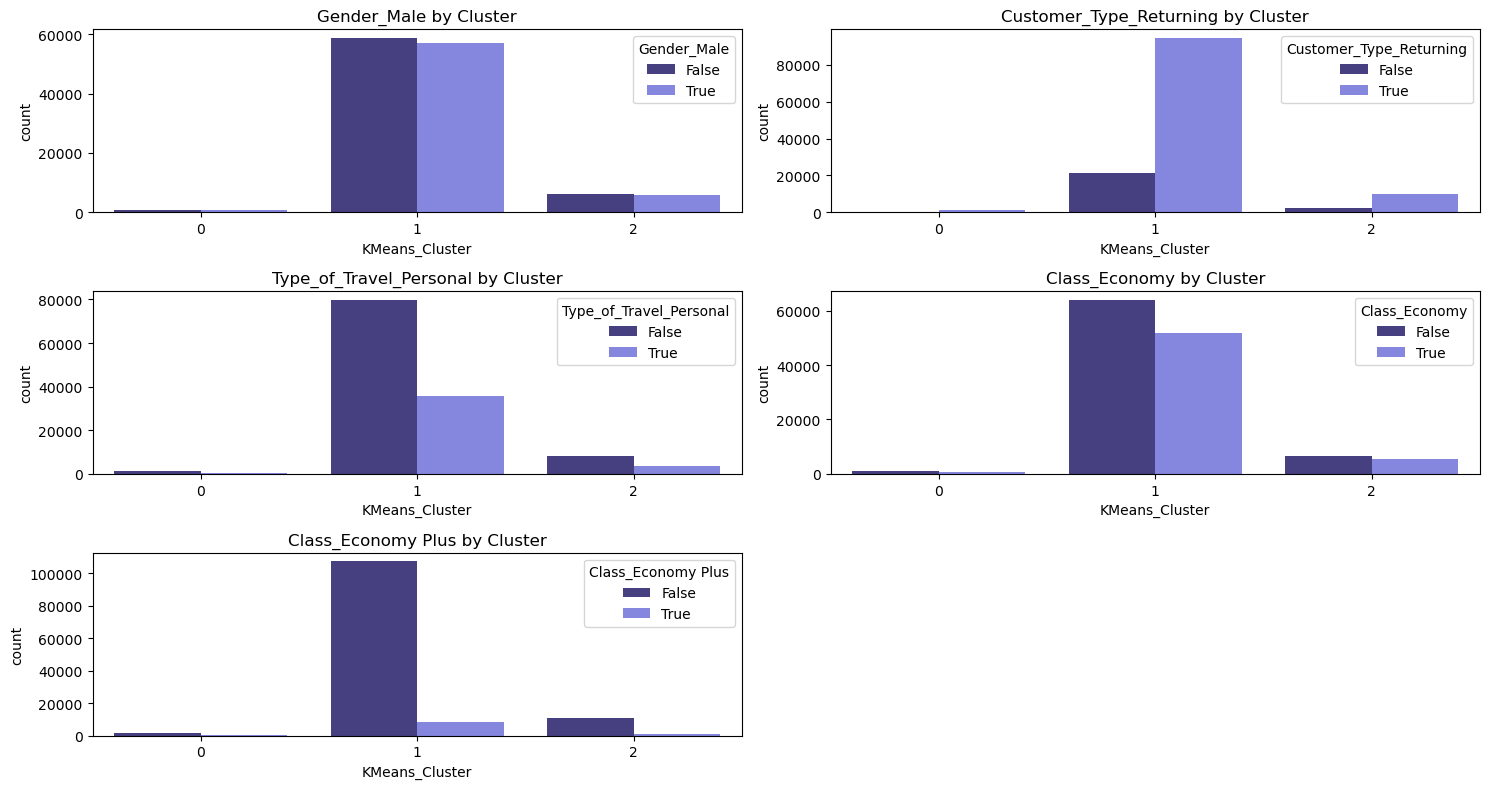

In [35]:
plt.figure(figsize=(15,8))

for i, col in enumerate(features.iloc[:,-6:-1].columns,1):
    plt.subplot(3, 2, i)
    sns.countplot(data=features, x='KMeans_Cluster', hue=col, palette=custom_palette[0:2])
    plt.title(f"{col} by Cluster")
plt.tight_layout()
plt.show()

### Note:
Gender is evenly distributed accross the three clusters. Returning business class passengers seem to dominate cluster 1 (the biggest cluster). Not much can be said about the third cluster.

## 3.2. HDBSCAN Clustering
This is a scalable version of DBSCAN that handles large datasets better. More information on this library [here](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html#selecting-min-samples).

In [36]:
# Using a random sample for tuning hyper parameters
rng = np.random.default_rng(seed=55) 
random_indices = rng.choice(X.shape[0], size=12000, replace=False)
X_sample = X[random_indices]

results = []

for min_cluster_size in [5, 15, 30, 50, 100]:
    for min_samples in [1, 5, 10, 15]:
            
            clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
            labels = clusterer.fit_predict(X_sample)

            # Remove noise points (-1) for silhouette score
            mask = labels != -1
            if np.sum(mask) > 1 and len(set(labels[mask])) > 1:  # check for points that are not noise and at lest 2 clusters
                sil_score = silhouette_score(X_sample[mask], labels[mask])
            else:
                sil_score = np.nan

            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)

            results.append({
                'min_cluster_size': min_cluster_size,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette_score': round(sil_score, 4) if not np.isnan(sil_score) else None
            })

# Sort to see the best combinations
sorted_results = sorted(
    results, 
    key=lambda x: (x['silhouette_score'] if x['silhouette_score'] is not None else -1), 
    reverse=True
)

for r in sorted_results[:10]: # show top 10 combinations
    print(r)


{'min_cluster_size': 15, 'min_samples': 1, 'n_clusters': 2, 'n_noise': 43, 'silhouette_score': 0.8152}
{'min_cluster_size': 5, 'min_samples': 5, 'n_clusters': 2, 'n_noise': 96, 'silhouette_score': 0.8142}
{'min_cluster_size': 5, 'min_samples': 10, 'n_clusters': 2, 'n_noise': 788, 'silhouette_score': 0.7175}
{'min_cluster_size': 5, 'min_samples': 15, 'n_clusters': 3, 'n_noise': 1276, 'silhouette_score': 0.6978}
{'min_cluster_size': 5, 'min_samples': 1, 'n_clusters': 10, 'n_noise': 251, 'silhouette_score': 0.5756}
{'min_cluster_size': 30, 'min_samples': 1, 'n_clusters': 3, 'n_noise': 2500, 'silhouette_score': 0.2684}
{'min_cluster_size': 30, 'min_samples': 10, 'n_clusters': 2, 'n_noise': 10163, 'silhouette_score': 0.2018}
{'min_cluster_size': 50, 'min_samples': 10, 'n_clusters': 2, 'n_noise': 10163, 'silhouette_score': 0.2018}
{'min_cluster_size': 100, 'min_samples': 10, 'n_clusters': 2, 'n_noise': 10163, 'silhouette_score': 0.2018}
{'min_cluster_size': 50, 'min_samples': 5, 'n_clusters'

### Note:
Eventhough the top 3 combinations above produce the highest silhouette scores they split the data in only two tight clusters. To compare with the KMeans results, the best combination for 3 clusters will be selected, that is min_cluster_size = 5, min_samples = 15 and a score of 0.6978

In [37]:

clusterer = hdbscan.HDBSCAN(min_cluster_size = 5, min_samples=15)
labels = clusterer.fit_predict(X)

In [38]:
features['HDBSCAN_Cluster'] = labels
features['HDBSCAN_Cluster'].value_counts()

HDBSCAN_Cluster
 1    129109
-1       373
 0         5
Name: count, dtype: int64

### Note: 
When fit to the whole data set HDBSCAN did not split the data in 3 clusters, but instead formed one big cluster plus some points labelled as noise. Tuning the parameters with the whole data set is not possible due to the required computational cost.

In [39]:
# checking feature means per cluster to understand the clusters
cluster_profiles = features.groupby('HDBSCAN_Cluster').mean(numeric_only=True)
display(cluster_profiles.T)


HDBSCAN_Cluster,-1,0,1
Age,36.962466,43.0,39.435748
Flight_Distance,1300.546917,1979.2,1189.861342
Departure_Delay,308.616622,406.6,13.778908
Arrival_Delay,344.160858,401.2,14.125483
Departure_and_Arrival_Time_Convenience,3.152815,3.8,3.211891
Ease_of_Online_Booking,2.804290,3.6,2.888273
Checkin_Service,3.139410,3.8,3.306725
Online_Boarding,3.112601,3.8,3.348248
Gate_Location,2.927614,3.8,2.977043
Onboard_Service,3.219839,3.2,3.383838


### Note:
One big homogeneous group (cluster 1) and some edge cases (clusters -1 and 0) with slightly longer flights and extensive delays 

## 3.3. Cluster Comparison and Interpretation

**KMeans** was able to split the data into three clusters:
- A small cluster of 1798 passengers who have experienced longer flight delays.
- A big cluster of 115711 passengers that have bigger proportions of frequent fliers that travel for work in business class.
- A medium cluster of 11978 passengers that doesn't seem to have major differences with the big cluster.

**HDBSCAN**, as an algorithm that identifies dense regions, has only found one big homogeneous cluster and some noise/outliers points that seem to be passengers who have experienced extensive flight delays and/or taken longer flights.

# 4. Dimensionality Reduction with PCA

## 4.1. Apply PCA

In [40]:
# Apply PCA with all features as components
pca = PCA(n_components= None)  
X_pca = pca.fit_transform(X)

# Explained variance
explained_var = pca.explained_variance_ratio_
print("Explained variance per component:\n", explained_var)

Explained variance per component:
 [0.67445216 0.07275623 0.04290659 0.03666596 0.02833157 0.02462362
 0.0152361  0.01476732 0.0118511  0.01083204 0.01005764 0.00918692
 0.00690778 0.0067305  0.00622937 0.00538323 0.00486739 0.00467246
 0.00397777 0.00319247 0.00252805 0.00237525 0.00146846]


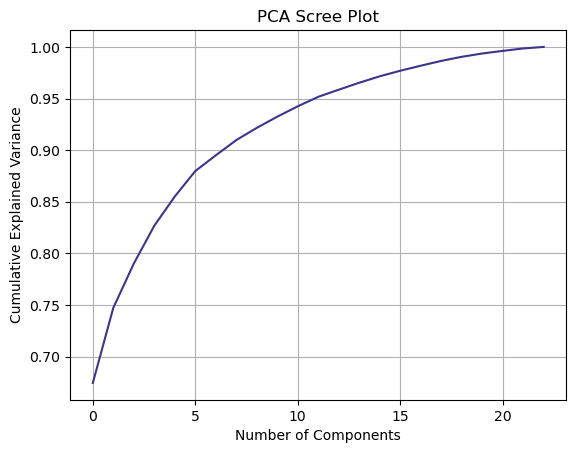

In [41]:
# Investigating optimal number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_), color=custom_palette[0])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.title('PCA Scree Plot')
plt.show()

### Note:
The first three components explain about 80% of the variance.

In [42]:
# Fitting PCA again with 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

## 4.2. Interpret PCA Components

In [43]:
# Drop the cluster labels and get feature names
features_nc = features.drop(columns=['KMeans_Cluster', 'HDBSCAN_Cluster'])
feature_names = features_nc.columns 

# PCA components (each column is a principal component, each row a feature)
loadings = pd.DataFrame(pca.components_, columns=feature_names,
                        index=['PC1', 'PC2', 'PC3'])

print(loadings.T)


                                             PC1       PC2       PC3
Age                                    -0.001594  0.043750 -0.061893
Flight_Distance                        -0.000106  0.117871 -0.140784
Departure_Delay                         0.730771  0.016517 -0.007296
Arrival_Delay                           0.682431  0.001551  0.001474
Departure_and_Arrival_Time_Convenience -0.001200  0.082532 -0.058844
Ease_of_Online_Booking                 -0.002033  0.078888 -0.204160
Checkin_Service                        -0.006838  0.757635  0.596545
Online_Boarding                        -0.005397  0.207176 -0.212090
Gate_Location                           0.000838  0.015352 -0.139065
Onboard_Service                        -0.005314  0.229179 -0.092693
Seat_Comfort                           -0.003241  0.146406 -0.192180
Leg_Room_Service                        0.001442  0.173687 -0.111127
Cleanliness                            -0.002762  0.223620 -0.320589
Food_and_Drink                    

### Note:
Here are the features that contributed the most to each component:
- PC1: Strong positive contributions: Departure_Delay (+0.73), Arrival_Delay (+0.68).

    - **PC1 is a "Flight Delays"** component. Passengers with high PC1 scores experienced extensive delays.

- PC2: Strong positive contributions: Checkin_Service (+0.75), Inflight_Entertainment(+0.26)
Moderate positive contributions: Onboard_Service (+0.23), Cleanliness (+0.22), Online_Boarding (+0.21), Inflight_Service (+0.20), Baggage_Handling (+0.20).

    - **PC2 is a "Overall Service Experience"** component. Passengers with high PC2 scores are generally satisfied with the overall flight experience, in particular with the check in service and inflight entertainment.

- PC3: Strong negative contributions: Inflight_Entertainment (-0.39), Food_and_Drink (-0.33), Cleanliness (-0.32), Inflight_Wifi_Service (-0.24).

    - **PC3 is a "Tech & comfort dissatisfaction"** component. Passengers with low PC3 scores were unhappy with inflight entertainment, food, Wi-Fi, and cleanliness.

## 4.3. Visualize PCA Results

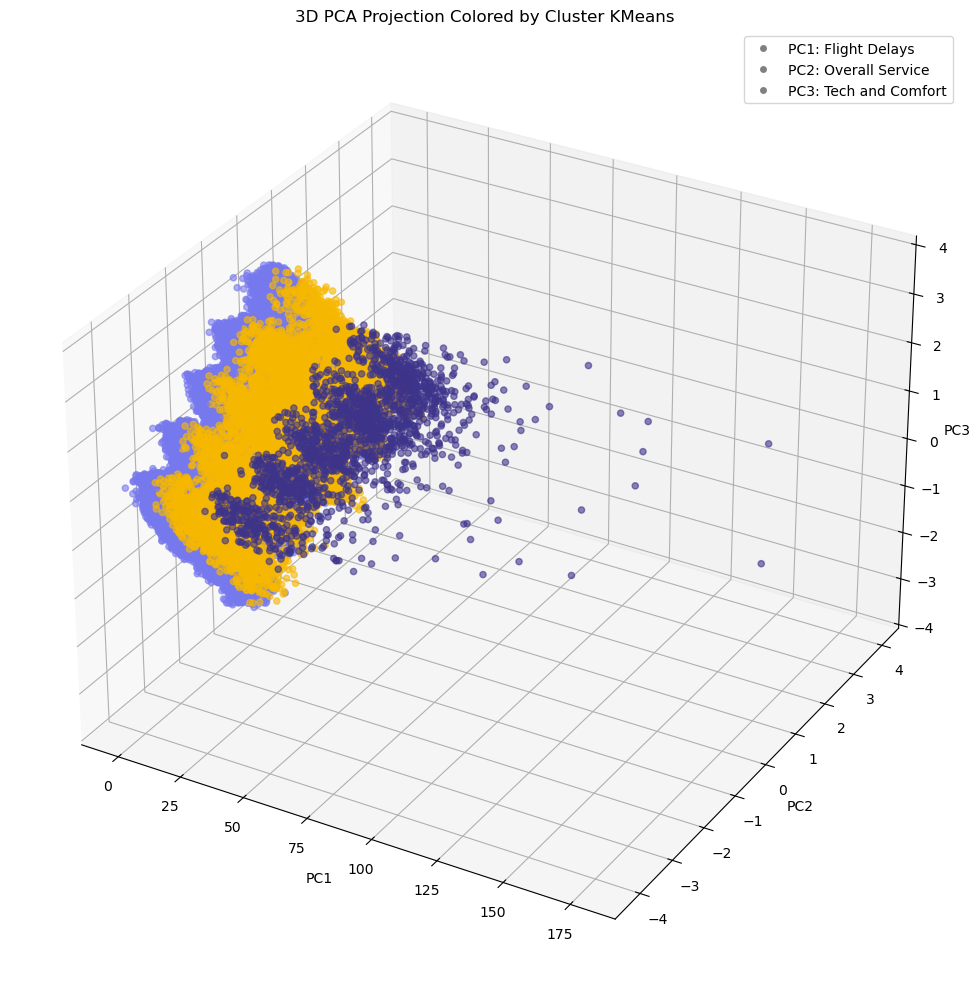

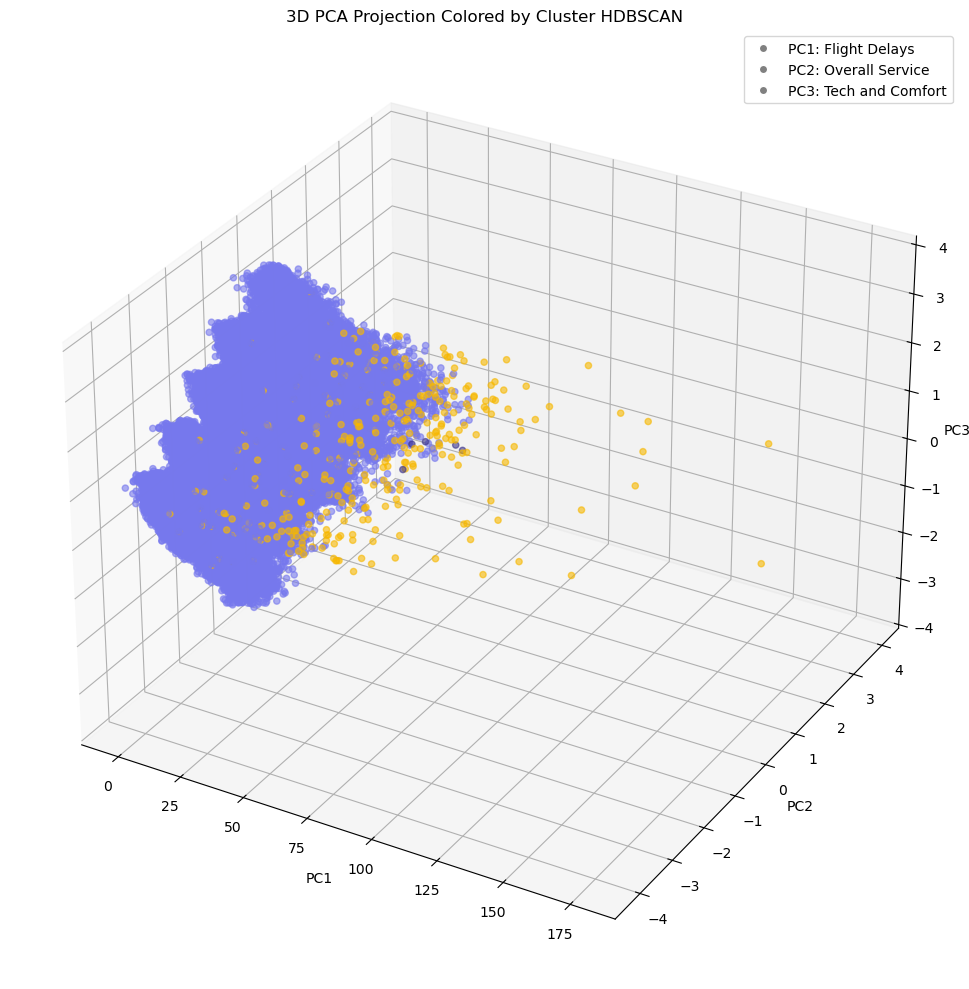

In [44]:
# Convert PCA data to a DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])

# Reset indices for both DataFrames
pca_df = pca_df.reset_index(drop=True)
features = features.reset_index(drop=True)

pca_df['KMeans_Cluster'] = features['KMeans_Cluster']  # cluster labels from KMeans
pca_df['HDBSCAN_Cluster'] = features['HDBSCAN_Cluster']  # cluster labels from KMeans

# Plot 1
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# color the clusters
palette = custom_palette[:len(pca_df['KMeans_Cluster'].unique())]  
colors = [palette[int(label)] for label in pca_df['KMeans_Cluster']]

ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=colors, s=20, alpha=0.6)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3', labelpad=1) # Avoiding cutting off label
ax.set_title('3D PCA Projection Colored by Cluster KMeans')

# Custom legend for PC meanings
legend_elements = [
    Line2D([0], [0], color='w', label='PC1: Flight Delays', marker='o', markerfacecolor='gray'),
    Line2D([0], [0], color='w', label='PC2: Overall Service', marker='o', markerfacecolor='gray'),
    Line2D([0], [0], color='w', label='PC3: Tech and Comfort', marker='o', markerfacecolor='gray')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Plot 2
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# color the clusters
palette = custom_palette[:len(pca_df['HDBSCAN_Cluster'].unique())]  # Ensure the palette matches the number of clusters
colors = [palette[int(label)] for label in pca_df['HDBSCAN_Cluster']]

ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=colors, s=20, alpha=0.6)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3', labelpad=1) # Avoiding cutting off label
ax.set_title('3D PCA Projection Colored by Cluster HDBSCAN')

# Custom legend for PC meanings
legend_elements = [
    Line2D([0], [0], color='w', label='PC1: Flight Delays', marker='o', markerfacecolor='gray'),
    Line2D([0], [0], color='w', label='PC2: Overall Service', marker='o', markerfacecolor='gray'),
    Line2D([0], [0], color='w', label='PC3: Tech and Comfort', marker='o', markerfacecolor='gray')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()



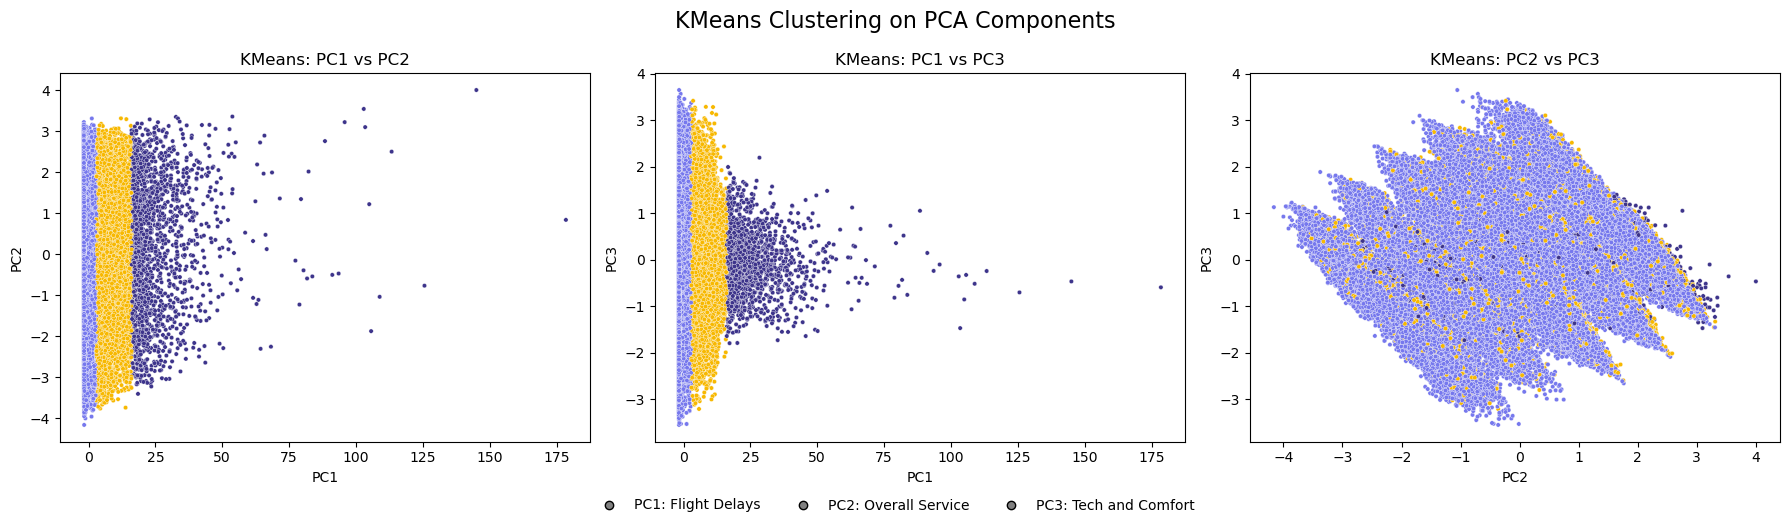

In [45]:
# Set up figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
pairs = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC2', 'PC3')]

for ax, (x, y) in zip(axes, pairs):
    scatter = sns.scatterplot(data=pca_df, x=x, y=y, hue='KMeans_Cluster', palette = custom_palette[0:3], s=10, ax=ax)
    ax.set_title(f'KMeans: {x} vs {y}')
    ax.legend().remove()

fig.suptitle('KMeans Clustering on PCA Components', fontsize=16)

# Create custom legend entries for PC meanings
pc_legend_elements = [
    Line2D([0], [0], color='none', label='PC1: Flight Delays', marker='o', markerfacecolor='gray'),
    Line2D([0], [0], color='none', label='PC2: Overall Service', marker='o', markerfacecolor='gray'),
    Line2D([0], [0], color='none', label='PC3: Tech and Comfort', marker='o', markerfacecolor='gray')
]

# Add custom legend outside the plot
fig.legend(handles=pc_legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=False)

plt.tight_layout()
plt.show()


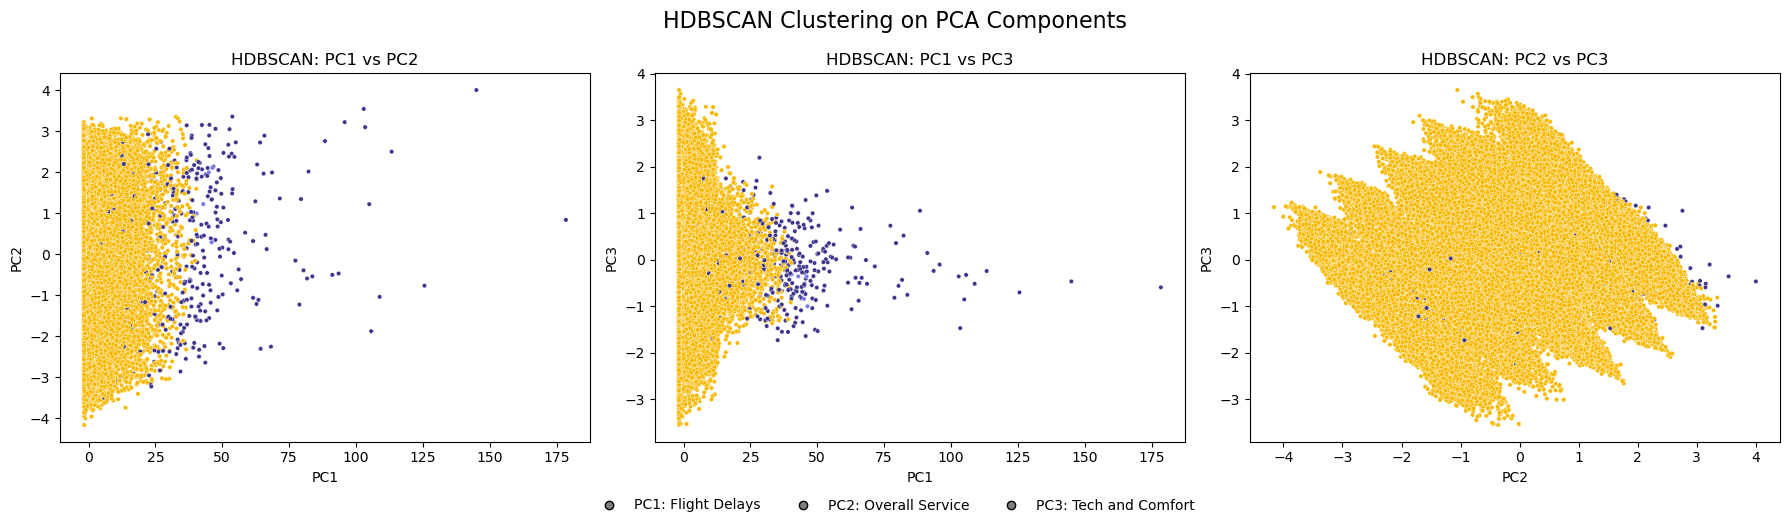

In [46]:
# Repeat for HDBSCAN
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (x, y) in zip(axes, pairs):
    sns.scatterplot(data=pca_df, x=x, y=y, hue='HDBSCAN_Cluster', palette=custom_palette[0:3], s=10, ax=ax)
    ax.set_title(f'HDBSCAN: {x} vs {y}')
    ax.legend().remove()

fig.suptitle('HDBSCAN Clustering on PCA Components', fontsize=16)

# Create custom legend entries for PC meanings
pc_legend_elements = [
    Line2D([0], [0], color='none', label='PC1: Flight Delays', marker='o', markerfacecolor='gray'),
    Line2D([0], [0], color='none', label='PC2: Overall Service', marker='o', markerfacecolor='gray'),
    Line2D([0], [0], color='none', label='PC3: Tech and Comfort', marker='o', markerfacecolor='gray')
]

# Add custom legend outside the plot
fig.legend(handles=pc_legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=False)

plt.tight_layout()
plt.show()

# 5. Final Analysis and Insights

## 5.1. Compatibility Check

PCA, like KMeans and DBSCAN, also showed flight delays as the major component in the data variance, but was able to identify two other underlying patterns in the data that the clustering analysis couldn't: one related to overall service and one related to tech and comfort satisfaction.

Clusters are not completely separated in the PCA space, as expected from clustering real-world customer experiences, which often exist on spectrums with not clean divisions.

## 5.2. Key Observations

For short flight delays (low PC1), the service values (PC1/PC2) are very extreme, indicating that some passengers are:
- very satisfied → good flight + good service = delighted.
- very dissatisfied → maybe expectations were high, or service was bad despite punctuality.

However, as flight delays increase the satisfaction levels tend to be more neutral (closer to zero), especially for the tech and comfort component. This tells that when delays are great, tech and comfort does not improve the passengers'experience. 

There seems to be a tradeoff between overall service and tech/comfort satisfaction, although there are slighly more people with negative tech/comfort satisfaction than positive. The biggest groups seem to be:
- negative overall service with positive tech/comfort satisfaction
- negative overall service with negative tech/comfort satisfaction

## 5.3. Conclusion

Two main passenger profiles emerged from KMeans clustering:

- A large cluster of business and/or frequent travellers who seem to rate online booking and inflight connectivity services negatively.

- A smaller cluster composed of passengers who experience significant flight delays and, as a result, show lower satisfaction overall.

Flight delays (PC1) are a major driver of negative perception.

- Passengers affected by long delays tend to cluster separately and show converging dissatisfaction in both service and comfort aspects, even when those aren’t directly related to timing.

Tech and Comfort satisfaction (PC3) shows a mild tradeoff with Overall Service (PC2).

- Many passengers are willing to forgive a lack of in-flight tech or comfort if service is strong — and vice versa. The largest segments had low overall service satisfaction, especially among economy travellers, first time travellers and those flying for personal reasons.

Digital interactions matter.

- Features like ease of online booking and inflight Wi-Fi are positively correlated, signalling that passengers judge their experience as a seamless journey — not just a flight.

- Improving digital services could lift ratings in other related areas.

Correlated ratings suggest bundled perception.

- Passengers rate seat comfort, entertainment, cleanliness, and food in similar patterns — meaning improving one can positively influence the perception of others.

**Recommendations to the airline:**

Invest in punctuality — delays are deeply tied to negative overall experience and cluster heavily.

Enhance overall service, specially the check in service and inflight entertainment and particularly for economy passengers.

Prioritize digital convenience and connectivity across the customer journey — from booking to onboard, especially for business travellers.

Target customer segments with tailored strategies (i.e. ticket discounts for first time travellers, comfort upgrades for returning customers, free wifi for business passengers )

